<h1>Q1</h1>

C:\Users\user\AppData\Local\Temp\ipykernel_7328\1932494293.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


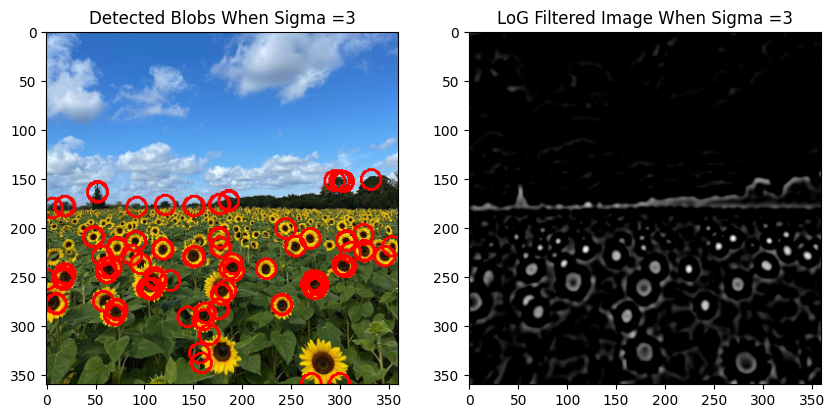

Number of detected blobs: 106


In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Define the LoG filter parameters
sigma = 3 # scale of the filter
hw = 3 * sigma # half width of the filter
X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
# scale normalized filter using LoG formula
log_filter = 1 / (2 * np.pi * sigma**2) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# Apply the LoG filter to the grayscale image using convolution
filtered_img = cv.filter2D(gray, -1, log_filter)

# Find local maxima in the filtered image
local_maxima = (filtered_img == cv.dilate(filtered_img, np.ones((3, 3))))

# Get the coordinates of the detected local maxima
maxima_coordinates = np.argwhere(local_maxima)

# Create a list of detected blobs as (x, y) coordinates and corresponding radii
blobs = []

# Define a threshold to filter out weak blobs
threshold = 45 # Threshold can be adjusted based on the image
for i in maxima_coordinates:
    if filtered_img[i[0], i[1]] > threshold:
        blobs.append((i[1], i[0]))  # (x, y)

# Draw the detected blobs on the original image
result = img.copy()
for blob in blobs:
    cv.circle(result, blob, 10, (0, 0, 255), 2)  # Draw circles with a radius of 10 pixels

# Display the result
plt.subplots(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title("Detected Blobs When Sigma =" + str(sigma))

plt.subplot(1, 2, 2)
plt.imshow(filtered_img, cmap='gray')
plt.title("LoG Filtered Image When Sigma =" + str(sigma))

plt.show()

# Report the number of detected blobs
print("Number of detected blobs:", len(blobs))


<h1>Q3</h1>

In [3]:
img_1 = cv.imread('Images/Wadham.jpg', cv.IMREAD_COLOR)
img_2 = cv.imread('Images/British.jpg', cv.IMREAD_COLOR)

# Create a list to store the user selected points
points_img_1 = []

# Mouse Callback function 
def click_event(event, x, y, flags, param):
    global points_img_1

    if event == cv.EVENT_LBUTTONDOWN: # If the left mouse button is clicked, record the point
        points_img_1.append((x, y))
        cv.circle(img_1, (x, y), 5, (0, 255, 0), -1)
        cv.imshow("Image 1", img_1)

        if len(points_img_1) == 4: # If four points are selected, proceed with further processing
            compute_homography()

# Function to compute homography matrix and perform superimposition
def compute_homography():
    global points_img_1

    # Define the corresponding points in img_2 with the same aspect ratio as image1)
    points_img_2 = np.array([[0, 0], [img_2.shape[1], 0], [img_2.shape[1], img_2.shape[0]], [0, img_2.shape[0]]], dtype=np.float32)

    # Compute the homography matrix
    homography_matrix, _ = cv.findHomography(points_img_2, np.array(points_img_1, dtype=np.float32))

    # Warp img_2 to match the perspective of img_1
    warped_img_2 = cv.warpPerspective(img_2, homography_matrix, (img_1.shape[1], img_1.shape[0]))

    # Blend the warped img_2 onto img_1
    alpha = 0.4 # Blending parameter
    blended_img = cv.addWeighted(img_1, 1 - alpha, warped_img_2, alpha, 0)

    # Display the resulting image
    cv.imshow("Superimposed Image", blended_img)
    cv.imwrite("Images/Superimposed.jpg", blended_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

# Show the image and set the callback function for mouse events
cv.imshow("Image 1", img_1)
cv.setMouseCallback("Image 1", click_event)

cv.waitKey(0)
cv.destroyAllWindows()


<h1>Q4</h1>